In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score

In [3]:
# One-hot encoding for categorical attributes
def one_hot_encode(df):
    return pd.get_dummies(df)

In [5]:
# Load the Loan Dataset
data = pd.read_csv('loan.csv')
data.drop('Loan_ID', axis=1, inplace=True)
data['Loan_Status'] = data['Loan_Status'].map({'Y': 1, 'N': 0})
df_encoded = one_hot_encode(data)
X = df_encoded.drop('Loan_Status', axis=1).values
y = df_encoded['Loan_Status'].values

In [7]:
# Function to compute Euclidean distance
def euclidean_distance(instance1, instance2):
    # print(instance1, instance2)
    sq_difference = (instance1 - instance2) ** 2
    sum_of_sq_difference = np.sum(sq_difference)
    euclidean_distance = np.sqrt(sum_of_sq_difference)
    # print(euclidean_distance)
    return euclidean_distance

In [9]:
# Function to get nearest neighbors
def get_neighbors(train, test_row, k):
    distances = []
    for train_row in train:
        dist = euclidean_distance(test_row, train_row[:-1])
        distances.append((train_row, dist))
    distances.sort(key=lambda tup: tup[1])
    neighbors = []
    for i in range(k):
        neighbors.append(distances[i][0])
    return neighbors

In [11]:
# Function to predict the class
def predict_classification(train, test_row, k):
    neighbors = get_neighbors(train, test_row, k)
    output_values = [row[-1] for row in neighbors]
    prediction = max(set(output_values), key=output_values.count)
    return prediction

In [13]:
# Stratified split function
def stratified_kfold(X, y, k):
    from collections import defaultdict
    folds = [([], []) for _ in range(k)]
    label_indices = defaultdict(list)

    # Organize indices by label
    for idx, label in enumerate(y):
        label_indices[label].append(idx)

    # Distribute indices of each label roughly evenly across the folds
    for indices in label_indices.values():
        np.random.shuffle(indices)
        for fold_idx, idx in enumerate(indices):
            # folds[fold_idx % k][0].append(X.iloc[idx])  # for parkinson & titanic
            # folds[fold_idx % k][1].append(y.iloc[idx])
            folds[fold_idx % k][0].append(X[idx])  # for loan dataset
            folds[fold_idx % k][1].append(y[idx])
    # Shuffle each fold to mix labels
    for fold in folds:
        combined = list(zip(*fold))
        np.random.shuffle(combined)
        fold[0][:], fold[1][:] = zip(*combined)

    return folds

In [15]:
# Evaluating the model over a range of k values
k_values = range(1, 52, 5)
# average_training_accuracies = []
average_testing_accuracies = []
# average_training_f1_scores = []
average_testing_f1_scores = []
accuracy_std_devs = []
f1_score_std_devs = []

# Perform manual stratified K-fold
folds = stratified_kfold(X, y, 10)

for k in k_values:
    # training_accuracies = []
    testing_accuracies = []
    # training_f1_scores = []
    testing_f1_scores = []

    for i in range(10):
        X_test, y_test = folds[i]
        X_train = [item for idx, fold in enumerate(folds) if idx != i for item in fold[0]]
        y_train = [item for idx, fold in enumerate(folds) if idx != i for item in fold[1]]

        # Normalize the features
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Prepare data for k-NN (add labels back to features for training)
        train_data = np.column_stack((X_train_scaled, y_train))
        test_data = np.column_stack((X_test_scaled, y_test))

        # Make predictions for each test instance and evaluate
        y_pred_train = [predict_classification(train_data, row[:-1], k) for row in train_data]
        y_pred_test = [predict_classification(train_data, row[:-1], k) for row in test_data]

        # training_accuracies.append(accuracy_score(y_train, y_pred_train))
        testing_accuracies.append(accuracy_score(y_test, y_pred_test))
        # training_f1_scores.append(f1_score(y_train, y_pred_train, average='macro'))
        testing_f1_scores.append(f1_score(y_test, y_pred_test, average='macro'))

    # Storing average scores
    # average_training_accuracies.append(np.mean(training_accuracies))
    average_testing_accuracies.append(np.mean(testing_accuracies))
    # average_training_f1_scores.append(np.mean(training_f1_scores))
    average_testing_f1_scores.append(np.mean(testing_f1_scores))

    # Calculate and append the standard deviation for the current k
    accuracy_std_devs.append(np.std(testing_accuracies))
    f1_score_std_devs.append(np.std(testing_f1_scores))

In [17]:
print("Summary Statistics:")
for k, accuracy, f1 in zip(k_values, average_testing_accuracies, average_testing_f1_scores):
    print(f"k: {k}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")

Summary Statistics:
k: 1, Accuracy: 0.7044, F1 Score: 0.6307
k: 6, Accuracy: 0.7063, F1 Score: 0.5919
k: 11, Accuracy: 0.7124, F1 Score: 0.5427
k: 16, Accuracy: 0.7208, F1 Score: 0.5294
k: 21, Accuracy: 0.7187, F1 Score: 0.5095
k: 26, Accuracy: 0.7104, F1 Score: 0.4826
k: 31, Accuracy: 0.7084, F1 Score: 0.4664
k: 36, Accuracy: 0.7043, F1 Score: 0.4549
k: 41, Accuracy: 0.7084, F1 Score: 0.4631
k: 46, Accuracy: 0.7168, F1 Score: 0.4883
k: 51, Accuracy: 0.7042, F1 Score: 0.4491


/var/folders/5c/brpsrb814g37ktn_slc6qxyc0000gn/T/ipykernel_46325/1273141979.py:4: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(k_values, average_testing_accuracies, yerr=accuracy_std_devs, label='Accuracy', marker='s', color='grey',


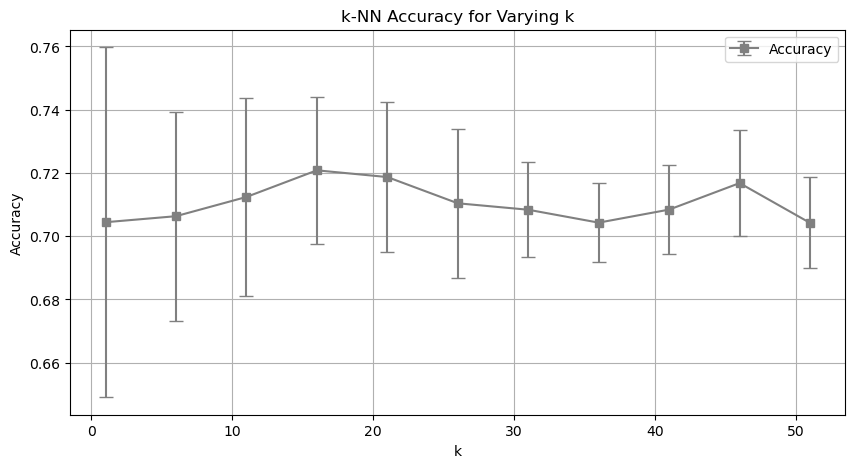

In [19]:
# Plotting Accuracy
plt.figure(figsize=(10, 5))
# plt.plot(k_values, average_training_accuracies, label='Training Accuracy', marker='o', color='blue')
plt.errorbar(k_values, average_testing_accuracies, yerr=accuracy_std_devs, label='Accuracy', marker='s', color='grey',
             linestyle='-', fmt='o', capsize=5)
plt.title('k-NN Accuracy for Varying k')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

/var/folders/5c/brpsrb814g37ktn_slc6qxyc0000gn/T/ipykernel_46325/3420289820.py:4: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(k_values, average_testing_f1_scores, yerr=f1_score_std_devs, label='F1 Score', marker='s', color='grey',


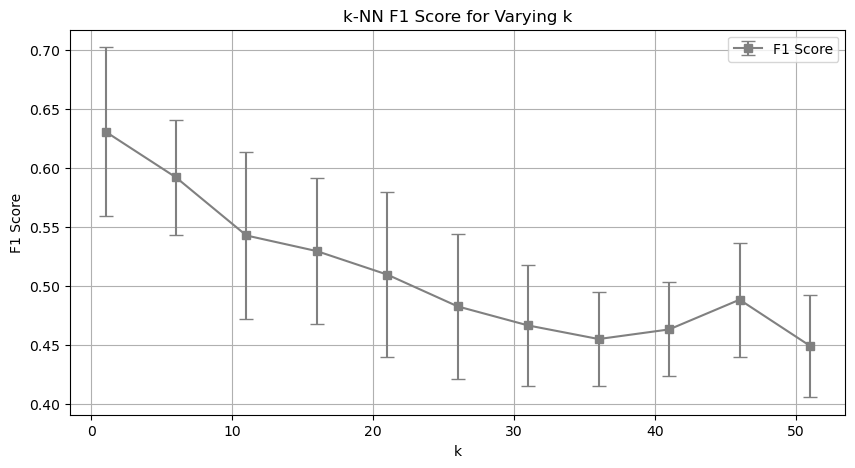

In [21]:
# Plotting F1 Score
plt.figure(figsize=(10, 5))
# plt.plot(k_values, average_training_f1_scores, label='Training F1 Score', marker='o', color='blue')
plt.errorbar(k_values, average_testing_f1_scores, yerr=f1_score_std_devs, label='F1 Score', marker='s', color='grey',
             linestyle='-', fmt='o', capsize=5)
plt.title('k-NN F1 Score for Varying k')
plt.xlabel('k')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()